In [1]:
import pandas as pd
import re
import missingno as msno
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Intro

 (From Kaggle, see https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018?select=2018_Financial_Data.csv)

There are in total 5 datasets: `2014_Financial_Data.csv`, `2015_Financial_Data.csv`, `2016_Financial_Data.csv`, `2017_Financial_Data.csv`, `2018_Financial_Data.csv`.

Each dataset contains 200+ financial indicators, that are commonly found in the 10-K filings each publicly traded company releases yearly, for a plethora of US stocks (on average, 4k stocks are listed in each dataset). 

The dataset was built by the author leveraging Financial Modeling Prep API and pandas_datareader.

### Important Remarks Regarding the Datasets
1. Some financial indicator values are missing (`nan` cells), so the user can select the best technique to clean each dataset (`dropna`, `fillna`, etc.).
2. There are outliers, meaning extreme values that are probably caused by mistypings. Also in this case, the user can choose how to clean each dataset (have a look at the 1% - 99% percentile values).
3. The third-to-last column, `Sector`, lists the sector of each stock. Indeed, in the US stock market each company is part of a sector that classifies it in a macro-area. Since all the sectors have been collected (Basic Materials, Communication Services, Consumer Cyclical, Consumer Defensive, Energy, Financial Services, Healthcare, Industrial, Real Estate, Technology and Utilities), the user has the option to perform per-sector analyses and comparisons.
4. The second-to-last column, `PRICE VAR [%]`, lists the percent price variation of each stock for the year. For example, if we consider the dataset `2015_Financial_Data.csv`, we will have:
    - 200+ financial indicators for the year 2015;
    - percent price variation for the year 2016 (meaning from the first trading day on Jan 2016 to the last trading day on Dec 2016).

5. The last column, `class`, lists a binary classification for each stock, where
    - for each stock, if the `PRICE VAR [%]` value is positive, `class = 1`. From a trading perspective, the `1` identifies those stocks that an hypothetical trader should **BUY** at the start of the year and sell at the end of the year for a profit.
    - for each stock, if the `PRICE VAR [%]` value is negative, `class = 0`. From a trading perspective, the `0` identifies those stocks that an hypothetical trader should **NOT BUY**, since their value will decrease, meaning a loss of capital.

The columns `PRICE VAR [%]` and `class` make possible to use the datasets for both classification and regression tasks:
- If the we wish to train a machine learning model so that it learns to classify those stocks that in buy-worthy and not buy-worthy, it is possible to get the targets from the class column;
- If the we wish to train a machine learning model so that it learns to predict the future value of a stock, it is possible to get the targets from the `PRICE VAR [%]` column.

# Basic Processing

In [2]:
# Load raw data
df2014 = pd.read_csv('data/2014_Financial_Data.csv')
df2015 = pd.read_csv('data/2015_Financial_Data.csv')
df2016 = pd.read_csv('data/2016_Financial_Data.csv')
df2017 = pd.read_csv('data/2017_Financial_Data.csv')
df2018 = pd.read_csv('data/2018_Financial_Data.csv')

yearly_df = {
    2014: df2014, 
    2015: df2015,
    2016: df2016,
    2017: df2017,
    2018: df2018,
}

In [3]:
# Inspect how does it look like -- The "Unnamed: 0" column is probably stock ticker
# Check that the df of different years all have same columns
for year, dataframe in yearly_df.items():
    print(dataframe.columns)

Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Receivables growth', 'Inventory Growth', 'Asset Growth',
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', '2015 PRICE VAR [%]', 'Class'],
      dtype='object', length=225)
Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Receivables growth', 'Inventory Growth', 'Asset Growth',
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', '2016 PRICE VAR [%]', 'Class'],
      dtype='object', length=225)
Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D E

In [4]:
# Function to convert camel case to snake case and handle pre-existing underscores
def camel_to_snake(name):
    # Insert an underscore between lowercase followed by uppercase
    s1 = re.sub('([a-z])([A-Z])', r'\1_\2', name)
    # Handle pre-existing underscores (avoid double underscores)
    s2 = re.sub('_+', '_', s1)
    return s2.lower()

In [5]:
# Then convert any camelCase to snake_case
for year, dataframe in yearly_df.items():
    dataframe.columns = [camel_to_snake(col) for col in dataframe.columns]

In [6]:
# Renaming columns to follow industry practice
for year, dataframe in yearly_df.items():
    dataframe.columns = [col.replace(' ', '_').lower() for col in dataframe.columns]

In [7]:
# Rename the first column as 'ticker'
for year, dataframe in yearly_df.items():
    dataframe.rename(columns={'unnamed:_0': 'ticker'}, inplace=True)

In [8]:
# Rename the price_var column removing the year
for year, dataframe in yearly_df.items():
    column_name = str(year+1) + '_price_var_[%]'
    dataframe.rename(columns={column_name: 'price_var_[%]'}, inplace=True)

In [9]:
# Rename successfully
for year, dataframe in yearly_df.items():
    print(dataframe.columns)

Index(['ticker', 'revenue', 'revenue_growth', 'cost_of_revenue',
       'gross_profit', 'r&d_expenses', 'sg&a_expense', 'operating_expenses',
       'operating_income', 'interest_expense',
       ...
       'receivables_growth', 'inventory_growth', 'asset_growth',
       'book_value_per_share_growth', 'debt_growth', 'r&d_expense_growth',
       'sg&a_expenses_growth', 'sector', 'price_var_[%]', 'class'],
      dtype='object', length=225)
Index(['ticker', 'revenue', 'revenue_growth', 'cost_of_revenue',
       'gross_profit', 'r&d_expenses', 'sg&a_expense', 'operating_expenses',
       'operating_income', 'interest_expense',
       ...
       'receivables_growth', 'inventory_growth', 'asset_growth',
       'book_value_per_share_growth', 'debt_growth', 'r&d_expense_growth',
       'sg&a_expenses_growth', 'sector', 'price_var_[%]', 'class'],
      dtype='object', length=225)
Index(['ticker', 'revenue', 'revenue_growth', 'cost_of_revenue',
       'gross_profit', 'r&d_expenses', 'sg&a_expens

In [10]:
df = pd.concat([df2014, df2015, df2016, df2017, df2018], axis=0)

# Examine Nullness

In [11]:
df.isnull().sum()

ticker                                            0
revenue                                        1171
revenue_growth                                 2088
cost_of_revenue                                1771
gross_profit                                   1207
r&d_expenses                                   2138
sg&a_expense                                   1669
operating_expenses                             1702
operating_income                               1101
interest_expense                               1719
earnings_before_tax                            1364
income_tax_expense                             1588
net_income_-_non-controlling_int               2259
net_income_-_discontinued_ops                  2259
net_income                                     1565
preferred_dividends                            2259
net_income_com                                 1391
eps                                            1301
eps_diluted                                    1292
weighted_ave

# Exploration of Predictors and Targets

From investopidia: https://www.investopedia.com/articles/basics/04/100804.asp


### Key Takeaways

* Stock prices are driven by a variety of factors, but ultimately the price at any given moment is due to the supply and demand at that point in time in the market.
* Fundamental factors drive stock prices based on a company's earnings and profitability from producing and selling goods and services.
* Technical factors relate to a stock's price history in the market pertaining to chart patterns, momentum, and behavioral factors of traders and investors.

### Fundamental Factors

In an efficient market, stock prices would be determined primarily by fundamentals, which, at the basic level, refer to a combination of two things:

1. An earnings base, such as earnings per share (EPS)
2. A valuation multiple, such as a P/E ratio

An owner of common stock has a claim on earnings, and earnings per share (EPS) is the owner's return on their investment. When you buy a stock, you are purchasing a proportional share of an entire future stream of earnings. That's the reason for the valuation multiple: It is the price you are willing to pay for the future stream of earnings.

Part of these earnings may be distributed as dividends, while the remainder will be retained by the company (on your behalf) for reinvestment. We can think of the future earnings stream as a function of both the current level of earnings and the expected growth in this earnings base.


#### The Earnings Base

Although we are using EPS, an accounting measure, to illustrate the concept of earnings base, there are other measures of earnings power. Many argue that cash-flow-based measures are superior. For example, free cash flow per share is used as an alternative measure of earnings power.

The way earnings power is measured may also depend on the type of company being analyzed. Many industries have their own tailored metrics. Real estate investment trusts (REITs), for example, use a special measure of earnings power called funds from operations (FFO). Relatively mature companies are often measured by dividends per share, which represents what the shareholder actually receives.

#### The Valuation Multiple

The valuation multiple expresses expectations about the future. As we already explained, it is fundamentally based on the discounted present value of the future earnings stream. Therefore, the two key factors here are:

1. The expected growth in the earnings base
2. The discount rate, which is used to calculate the present value of the future stream of earnings


A higher growth rate will earn the stock a higher multiple, but a higher discount rate will earn a lower multiple.

What determines the discount rate? First, it is a function of perceived risk. A riskier stock earns a higher discount rate, which, in turn, earns a lower multiple. Second, it is a function of inflation (or interest rates, arguably). Higher inflation earns a higher discount rate, which earns a lower multiple (meaning the future earnings are going to be worth less in inflationary environments).

#### Key Fundamental Factors

* The level of the earnings base (represented by measures such as EPS, cash flow per share, dividends per share)
* The expected growth in the earnings base
* The discount rate, which is itself a function of inflation
* The perceived risk of the stock

### Technical Factors

Things would be easier if only fundamental factors set stock prices. Technical factors are the mix of external conditions that alter the supply of and demand for a company's stock. Some of these indirectly affect fundamentals. For example, economic growth indirectly contributes to earnings growth.

Technical factors include the following.

#### Inflation

We mentioned it earlier as an input into the valuation multiple, but inflation is a huge driver from a technical perspective as well. Historically, low inflation has had a strong inverse correlation with valuations (low inflation drives high multiples and high inflation drives low multiples). Deflation, on the other hand, is generally bad for stocks because it signifies a loss in pricing power for companies.

#### Economic Strength of Market and Peers
Company stocks tend to track with the market and with their sector or industry peers. Some prominent investment firms argue that the combination of overall market and sector movements—as opposed to a company's individual performance—determines a majority of a stock's movement. (Research has suggested that economic/market factors account for 90% of it.) For example, a suddenly negative outlook for one retail stock often hurts other retail stocks as "guilt by association" drags down demand for the whole sector.

#### Substitutes
Companies compete for investment dollars with other asset classes on a global stage. These include corporate bonds, government bonds, commodities, real estate, and foreign equities. The relationship between demand for U.S. equities and their substitutes is hard to figure, but it plays an important role.

#### Incidental Transactions
Incidental transactions are purchases or sales of a stock that are motivated by something other than belief in the intrinsic value of the stock. These transactions include executive insider transactions, which are often pre-scheduled or driven by portfolio objectives. Another example is an institution buying or shorting a stock to hedge some other investment. Although these transactions may not represent official "votes cast" for or against the stock, they do impact supply and demand and, therefore, can move the price.

#### Demographics
Some important research has been done about the demographics of investors. Much of it concerns these two dynamics:

1. Middle-aged investors, peak earners who tend to invest in the stock market
2. Older investors, who tend to pull out of the market in order to meet the demands of retirement
3. 
The hypothesis is that the greater the proportion of middle-aged investors among the investing population, the greater the demand for equities and the higher the valuation multiples. 

#### Trends
Often a stock simply moves according to a short-term trend. On the one hand, a stock that is moving up can gather momentum, as "success breeds success" and popularity buoys the stock higher. On the other hand, a stock sometimes behaves the opposite way in a trend and does what is called reverting to the mean.

Unfortunately, because trends cut both ways and are more obvious in hindsight, knowing that stocks are "trendy" does not help us predict the future.

#### Liquidity
Liquidity is an important and sometimes under-appreciated factor. It refers to how much interest from investors a specific stock attracts. Walmart's stock, for example, is highly liquid and thus highly responsive to material news; the average small-cap company is less so. Trading volume is not only a proxy for liquidity, but it is also a function of corporate communications (that is, the degree to which the company is getting attention from the investor community).

Large-cap stocks have high liquidity—they are well followed and heavily transacted. Many small-cap stocks suffer from an almost permanent "liquidity discount" because they simply are not on investors' radar screens. 

#### News
While it is hard to quantify the impact of news or unexpected developments inside a company, industry, or the global economy, you can't argue that it does influence investor sentiment. The political situation, negotiations between countries or companies, product breakthroughs, mergers and acquisitions, and other unforeseen events can impact stocks and the stock market. Since securities trading happens across the world and markets and economies are interconnected, news in one country can impact investors in another, almost instantly.

News related to a specific company, such as the release of a company's earnings report, can also influence the price of a stock (particularly if the company is posting after a bad quarter).

In general, strong earnings generally result in the stock price moving up (and vice versa). But some companies that are not making that much money still have a rocketing stock price. This rising price reflects investor expectations that the company will be profitable in the future. However, regardless of the stock price, there are no guarantees that a company will fulfill investors' current expectations of becoming a high-earning company in the future.

#### Market Sentiment
Market sentiment refers to the psychology of market participants, individually and collectively. This is perhaps the most vexing category. Market sentiment is often subjective, biased, and obstinate. For example, you can make a solid judgment about a stock's future growth prospects, and the future may even confirm your projections, but in the meantime, the market may myopically dwell on a single piece of news that keeps the stock artificially high or low. And you can sometimes wait a long time in the hope that other investors will notice the fundamentals. 

Market sentiment is being explored by the relatively new field of behavioral finance. It starts with the assumption that markets are apparently not efficient much of the time, and this inefficiency can be explained by psychology and other social science disciplines. The idea of applying social science to finance was fully legitimized when Daniel Kahneman, Ph.D., a psychologist, won the 2002 Nobel Memorial Prize in Economic Sciences (the first psychologist to do so). Many of the ideas in behavioral finance confirm observable suspicions: that investors tend to overemphasize data that come easily to mind; that many investors react with greater pain to losses than with pleasure to equivalent gains; and that investors tend to persist in a mistake.

Some investors claim to be able to capitalize on the theory of behavioral finance. For the majority, however, the field is new enough to serve as the "catch-all" category, where everything we cannot explain is deposited.

### The Bottom Line
Different types of investors depend on different factors. Short-term investors and traders tend to incorporate and may even prioritize technical factors. Long-term investors prioritize fundamentals and recognize that technical factors play an important role. Investors who believe strongly in fundamentals can reconcile themselves to technical forces with the following popular argument: technical factors and market sentiment often overwhelm the short run, but fundamentals will set the stock price in the long-run. In the meantime, we can expect more exciting developments in the area of behavioral finance, especially since traditional financial theories cannot seem to explain everything that happens in the market.

### Separate Predictors and Targets

In [12]:
predictors = df.drop(columns=['class', 'price_var_[%]'])
price_var_sign = df[['class']]
price_var = df[['price_var_[%]']]

In [13]:
df.columns

Index(['ticker', 'revenue', 'revenue_growth', 'cost_of_revenue',
       'gross_profit', 'r&d_expenses', 'sg&a_expense', 'operating_expenses',
       'operating_income', 'interest_expense',
       ...
       'receivables_growth', 'inventory_growth', 'asset_growth',
       'book_value_per_share_growth', 'debt_growth', 'r&d_expense_growth',
       'sg&a_expenses_growth', 'sector', 'price_var_[%]', 'class'],
      dtype='object', length=225)

In [14]:
pd.set_option('display.max_seq_items', None)
print(predictors.columns)

Index(['ticker', 'revenue', 'revenue_growth', 'cost_of_revenue',
       'gross_profit', 'r&d_expenses', 'sg&a_expense', 'operating_expenses',
       'operating_income', 'interest_expense', 'earnings_before_tax',
       'income_tax_expense', 'net_income_-_non-controlling_int',
       'net_income_-_discontinued_ops', 'net_income', 'preferred_dividends',
       'net_income_com', 'eps', 'eps_diluted', 'weighted_average_shs_out',
       'weighted_average_shs_out_(dil)', 'dividend_per_share', 'gross_margin',
       'ebitda_margin', 'ebit_margin', 'profit_margin',
       'free_cash_flow_margin', 'ebitda', 'ebit', 'consolidated_income',
       'earnings_before_tax_margin', 'net_profit_margin',
       'cash_and_cash_equivalents', 'short-term_investments',
       'cash_and_short-term_investments', 'receivables', 'inventories',
       'total_current_assets', 'property,_plant_&_equipment_net',
       'goodwill_and_intangible_assets', 'long-term_investments', 'tax_assets',
       'total_non-current

In [15]:
# Reset option to avoid potential performance issues in other parts
pd.reset_option('display.max_seq_items')

### Initial Filtering of Predictors

Based on Investopedia, we decide to keep the following predictors --

#### Fundamental Factors:
1. EPS (`eps`, `eps_diluted`): Include as it directly relates to earnings power.
2. Revenue and Profitability (`revenue`, `net_income`, `gross_profit`, `operating_income`, `earnings_before_tax`): These are critical components of the earnings base.
3. Growth Metrics (`revenue_growth`, `eps_growth`, `net_income_growth`): These are reflective of the expected growth in earnings.
4. Valuation Metrics (`pe_ratio`, `price_to_sales_ratio`, `pb_ratio`, `dividend_yield`): They are essential for understanding how the market values the earnings and assets of a company.
5. Dividends (`dividend_per_share`, `dividends_per_share_growth`): Important for mature companies where dividends are a significant factor.

#### Technical Factors:
1. Market Cap (`market_cap`): Relates to liquidity and the size of the company.
2. Trading Volume (not explicitly listed, but can be derived or included as a data point): Reflects liquidity and investor interest.
3. Debt and Capital Structure (`total_debt`, `long-term_debt`, `debt_to_equity`, `net_debt_to_ebitda`): These can influence a company's risk profile and cost of capital.
4. Investment and Cash Flow (`operating_cash_flow`, `free_cash_flow`, `capital_expenditure`, `cash_and_cash_equivalents`): Reflects the company’s ability to generate cash and fund operations.

#### Market Sentiment:
1. Price Volatility and Ratios (`enterprise_value_over_ebitda`, `ev_to_sales`, `earnings_yield`, `free_cash_flow_yield`): These might capture some elements of market sentiment.
2. Investor Sentiment Indicators (not listed, but could include news sentiment analysis or social media sentiment data): These would represent the behavioral aspect of the market.

#### General Financial Health Indicators:
1. Liquidity Ratios (`current_ratio`, `quick_ratio`): To assess the company's ability to meet short-term obligations.
2. Profitability Ratios (`net_profit_margin`, `return_on_assets`, `return_on_equity`): Indicative of how efficiently a company is run.
3. Efficiency Ratios (`asset_turnover`, `inventory_turnover`, `receivables_turnover`): Reflective of how well the company utilizes its assets.

#### Remove Redundant or Highly Correlated Predictors:
* Remove items that are variations of the same measure (e.g., `weighted_average_shs_out` and `weighted_average_shs_out_(dil)`; just keep one).
* Combine growth metrics into a single predictor if they are highly correlated (e.g., `5y_revenue_growth_(per_share)` and `3y_revenue_growth_(per_share)` might be combined).
Use consolidated metrics rather than broken-down values when they convey the same information (e.g., `total_assets`, `total_liabilities`, `total_debt`).

#### Sector Information:
* Sector (`sector`): This categorical variable can capture industry-specific effects.

In [16]:
# Define lists of predictors for each category

fundamental_factors = [
    'eps', 'eps_diluted', 'revenue', 'net_income', 'gross_profit',
    'operating_income', 'earnings_before_tax', 'dividend_per_share',
    'revenue_growth', 'eps_growth', 'net_income_growth',
    'pe_ratio', 'price_to_sales_ratio', 'pb_ratio', 'dividend_yield'
]

technical_factors = [
    'market_cap',
    'total_debt', 'long-term_debt', 'debt_to_equity', 'net_debt_to_ebitda',
    'operating_cash_flow', 'free_cash_flow', 'capital_expenditure',
    'cash_and_cash_equivalents'
]

market_sentiment = [
    'enterprise_value_over_ebitda', 'ev_to_sales', 'earnings_yield', 'free_cash_flow_yield'
]

gen_fin_health = [
    'current_ratio', 'quick_ratio', 'net_profit_margin', 'return_on_assets', 'return_on_equity',
    'asset_turnover', 'inventory_turnover', 'receivables_turnover', 
    'total_assets', 'total_liabilities', 'total_debt', 'net_debt'
]

sector_info = [
    'sector'
]

# Combine all the lists into one
all_selected_columns = (
    fundamental_factors + 
    technical_factors +
    market_sentiment + 
    gen_fin_health + 
    sector_info
)

In [17]:
def pre_filter_predictor(df, columns):
    """
    Extract a subset of columns from a DataFrame safely.

    Only includes columns in the provided list if they exist in the DataFrame.
    Returns a tuple with the subset DataFrame and a set of missing column names.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to subset.
    - columns (list): Column names to include in the subset.

    Returns:
    - (pandas.DataFrame, set): A tuple with the subset DataFrame and a set of missing columns.
    """
    existing_columns = [col for col in columns if col in df.columns]
    return df[existing_columns], set(columns) - set(existing_columns)


In [18]:
predictors_selected, predictors_missing_col = pre_filter_predictor(predictors, all_selected_columns)

In [19]:
predictors_selected.shape[1]

46

In [20]:
# Successful!
predictors_missing_col

set()

**So we have reduce the number of predictors in each dataset from 223 to 46! This still seems a bit too many so we might use PCA to help us further reduce the number of predictors. But will hold on for now.**

In [21]:
# Summary of the clean data

In [22]:
predictors_selected.shape

(22077, 46)

In [23]:
predictors_selected.dtypes

eps                             float64
eps_diluted                     float64
revenue                         float64
net_income                      float64
gross_profit                    float64
operating_income                float64
earnings_before_tax             float64
dividend_per_share              float64
revenue_growth                  float64
eps_growth                      float64
net_income_growth               float64
pe_ratio                        float64
price_to_sales_ratio            float64
price_to_sales_ratio            float64
pb_ratio                        float64
dividend_yield                  float64
dividend_yield                  float64
market_cap                      float64
total_debt                      float64
long-term_debt                  float64
debt_to_equity                  float64
net_debt_to_ebitda              float64
operating_cash_flow             float64
free_cash_flow                  float64
capital_expenditure             float64


## Descriptive Statistics

In [24]:
print(predictors_selected.describe())

                eps   eps_diluted       revenue    net_income  gross_profit  \
count  2.077600e+04  2.078500e+04  2.090600e+04  2.051200e+04  2.087000e+04   
mean  -1.065748e+04 -1.073582e+04  5.161619e+09  3.886727e+08  1.970452e+09   
std    8.960977e+05  8.953487e+05  3.197314e+10  2.643759e+09  8.735750e+09   
min   -1.018709e+08 -1.018709e+08 -6.276160e+08 -2.304500e+10 -1.280800e+10   
25%   -3.900000e-01 -3.900000e-01  5.880737e+07 -9.018500e+06  3.035575e+07   
50%    6.400000e-01  6.300000e-01  4.352510e+08  1.864950e+07  1.943525e+08   
75%    2.020000e+00  1.980000e+00  2.287259e+09  1.579370e+08  8.806035e+08   
max    8.028004e+06  6.624003e+06  1.886894e+12  2.339970e+11  4.621600e+11   

       operating_income  earnings_before_tax  dividend_per_share  \
count      2.097600e+04         2.071300e+04        19818.000000   
mean       5.896979e+08         4.925003e+08            1.215392   
std        2.976454e+09         2.484345e+09           72.200951   
min       -1.933

# Missingness

Here we use the `missingno` (missing "no") library to visualize the patterns of missing data.

**Interpretation Strategies:**
* Randomness: If the missingness appears random without a discernible pattern across the matrix plot, it may suggest that the data is Missing Completely At Random (MCAR).
* Patterns or Bands: Systematic patterns or bands in the matrix plot may suggest that the data is Missing At Random (MAR) where missingness is systematic and related to other observed variables.
* Blocks: If you see blocks of white in the matrix plot, this suggests that there might be groups of data that are Missing Not At Random (MNAR), indicating a potential inherent problem with the data collection process.
* Correlation in Heatmap: High correlation in the heatmap suggests that the missingness of one variable is not independent of another, which is common with MAR or MNAR.

In [25]:
# Check the percentage of missing data in each column
missing = predictors_selected.isnull().mean() * 100
print(missing)

eps                              5.893011
eps_diluted                      5.852244
revenue                          5.304163
net_income                       7.088825
gross_profit                     5.467228
operating_income                 4.987091
earnings_before_tax              6.178376
dividend_per_share              10.232369
revenue_growth                   9.457807
eps_growth                       9.888119
net_income_growth               10.789509
pe_ratio                        10.182543
price_to_sales_ratio            10.341079
price_to_sales_ratio            10.214250
pb_ratio                        22.543824
dividend_yield                  14.938624
dividend_yield                  10.173484
market_cap                      13.910404
total_debt                       7.736558
long-term_debt                   8.642479
debt_to_equity                  10.481497
net_debt_to_ebitda              34.945871
operating_cash_flow              5.290574
free_cash_flow                   7

In [26]:
price_var_sign.isnull().sum()

class    0
dtype: int64

In [27]:
price_var.isnull().sum()

price_var_[%]    0
dtype: int64

<Axes: >

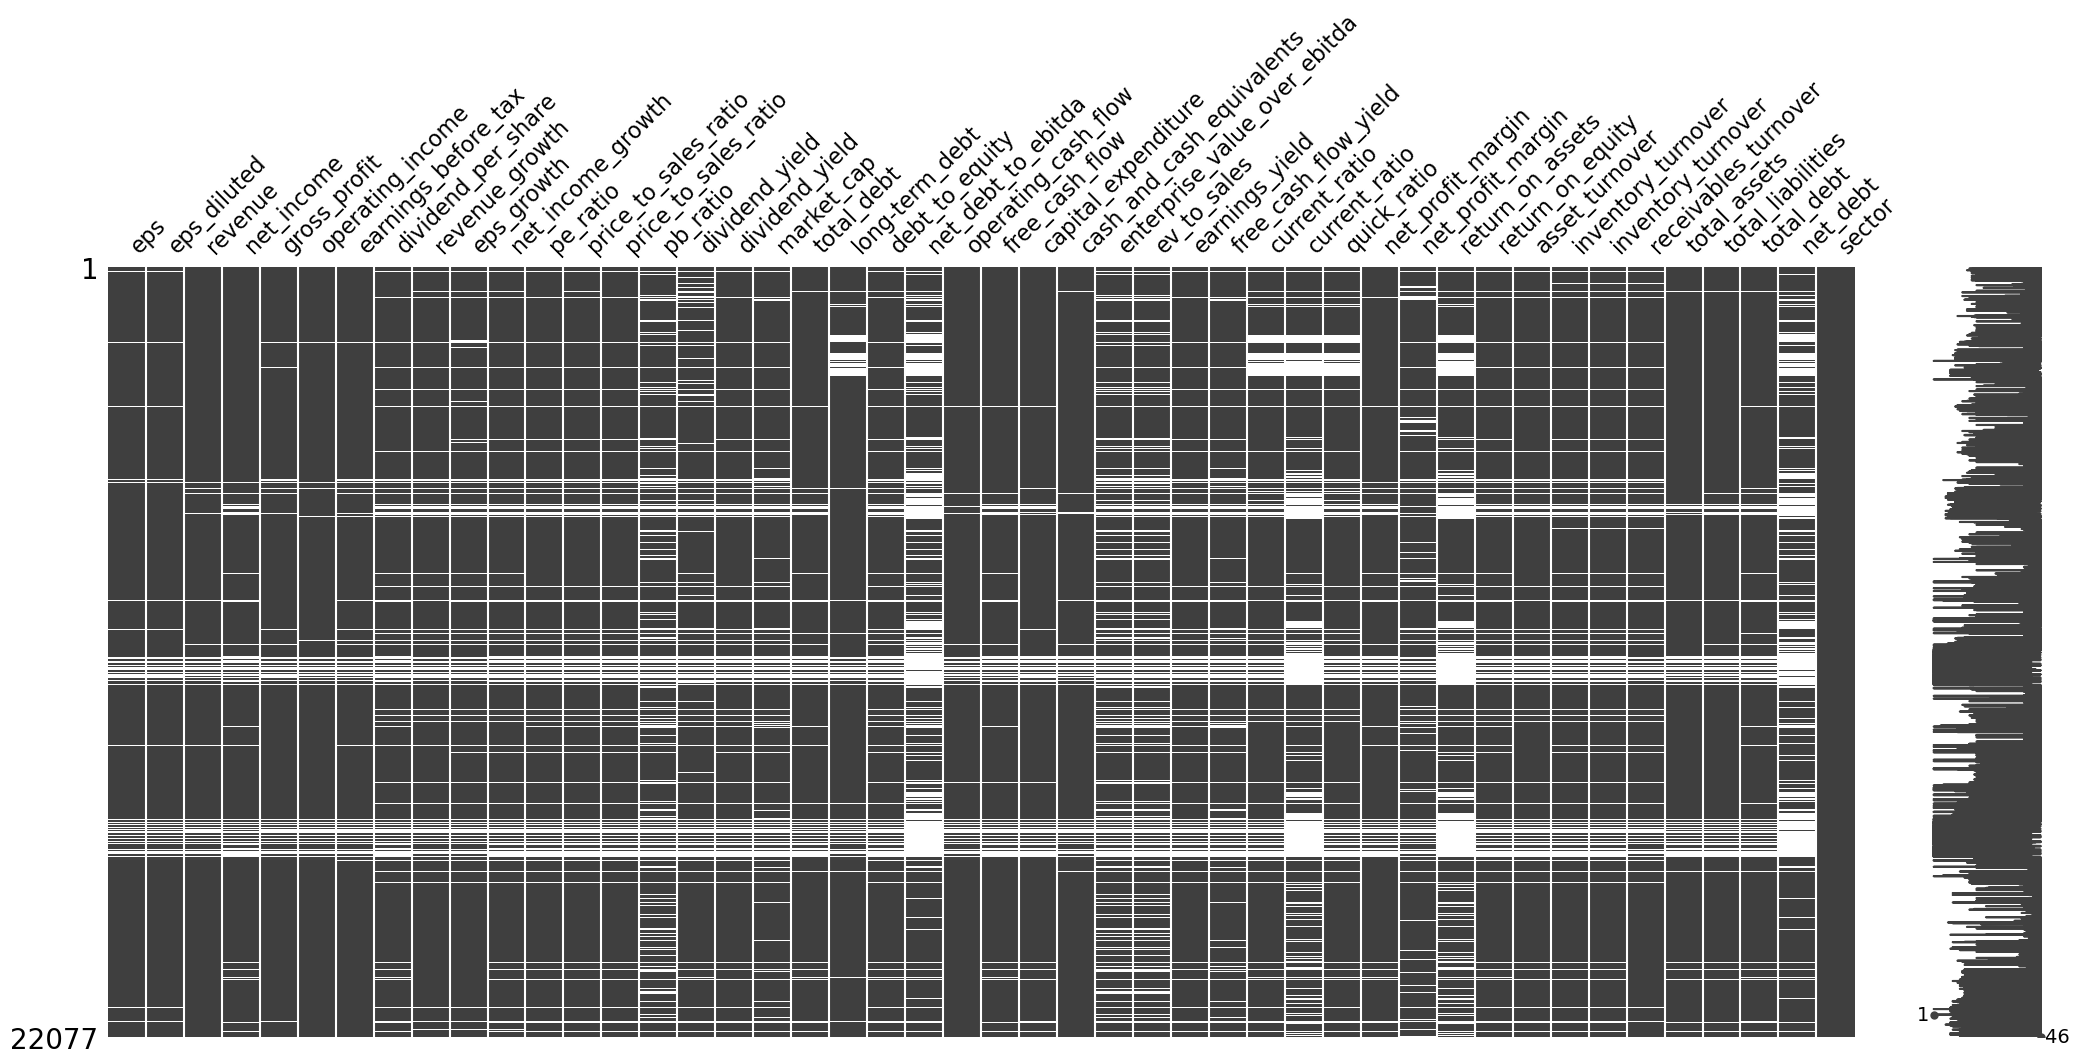

In [28]:
# Visualize the missingness pattern
msno.matrix(predictors_selected)

<Axes: >

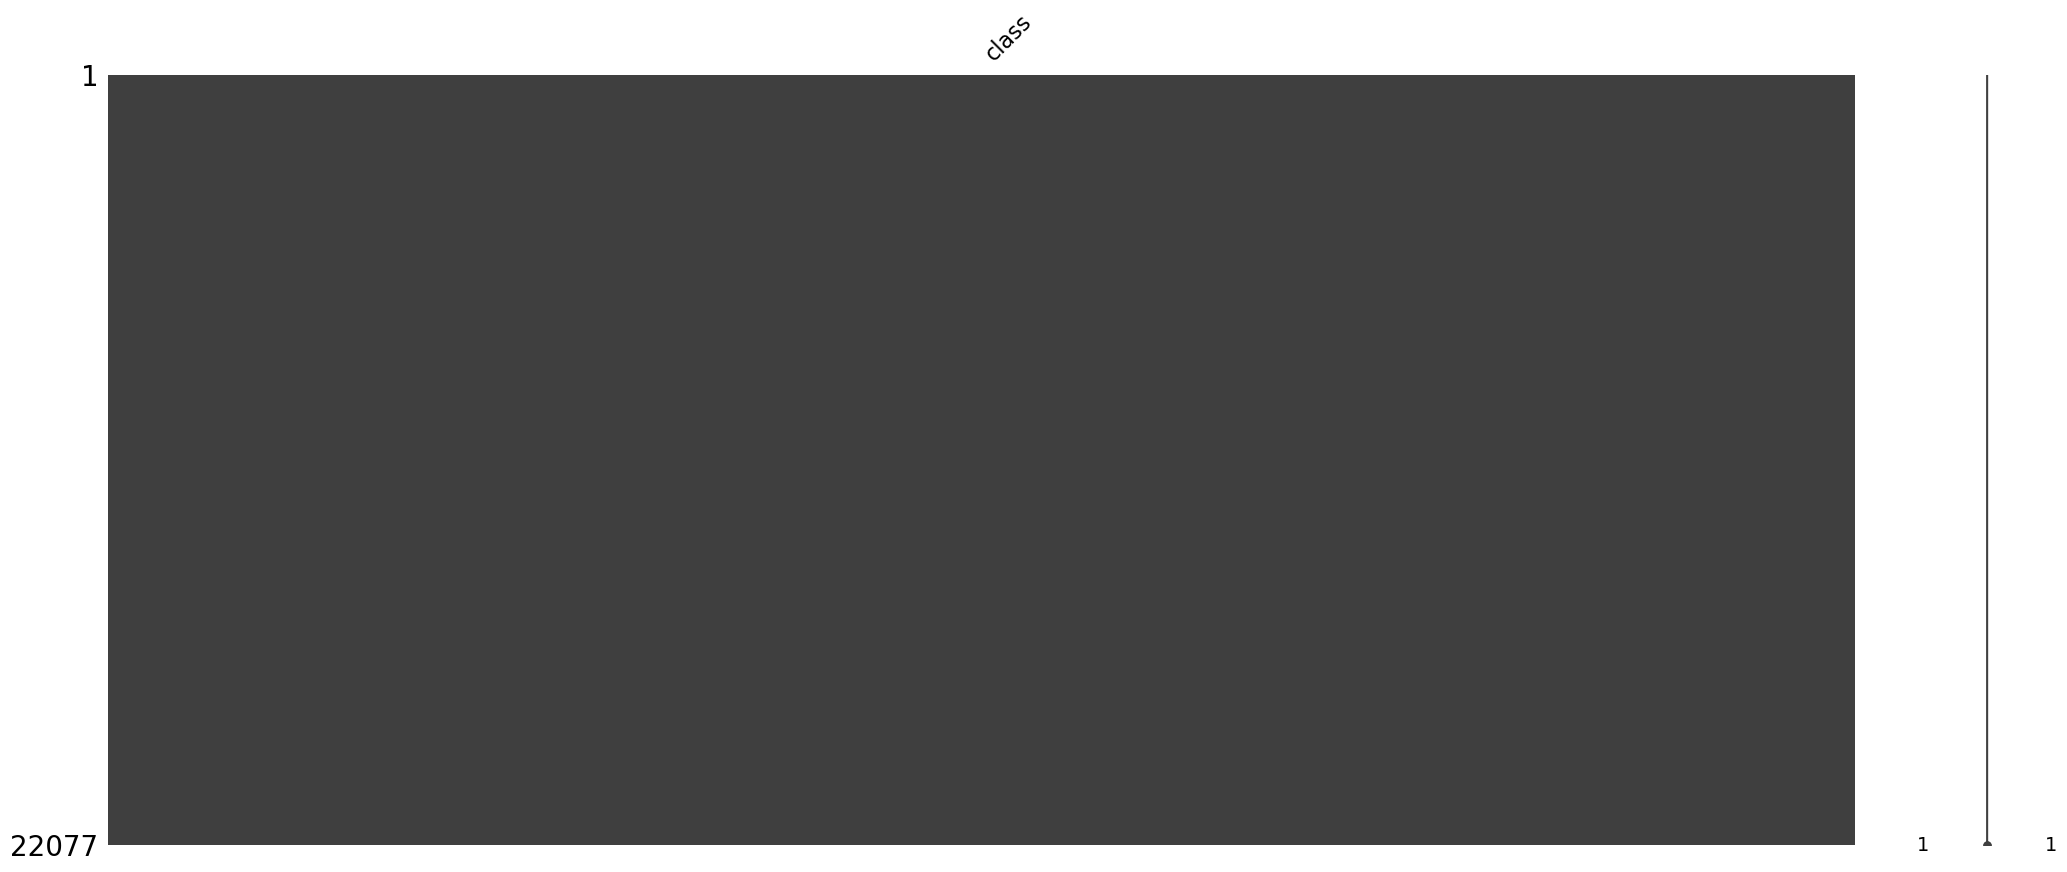

In [29]:
msno.matrix(price_var_sign)

<Axes: >

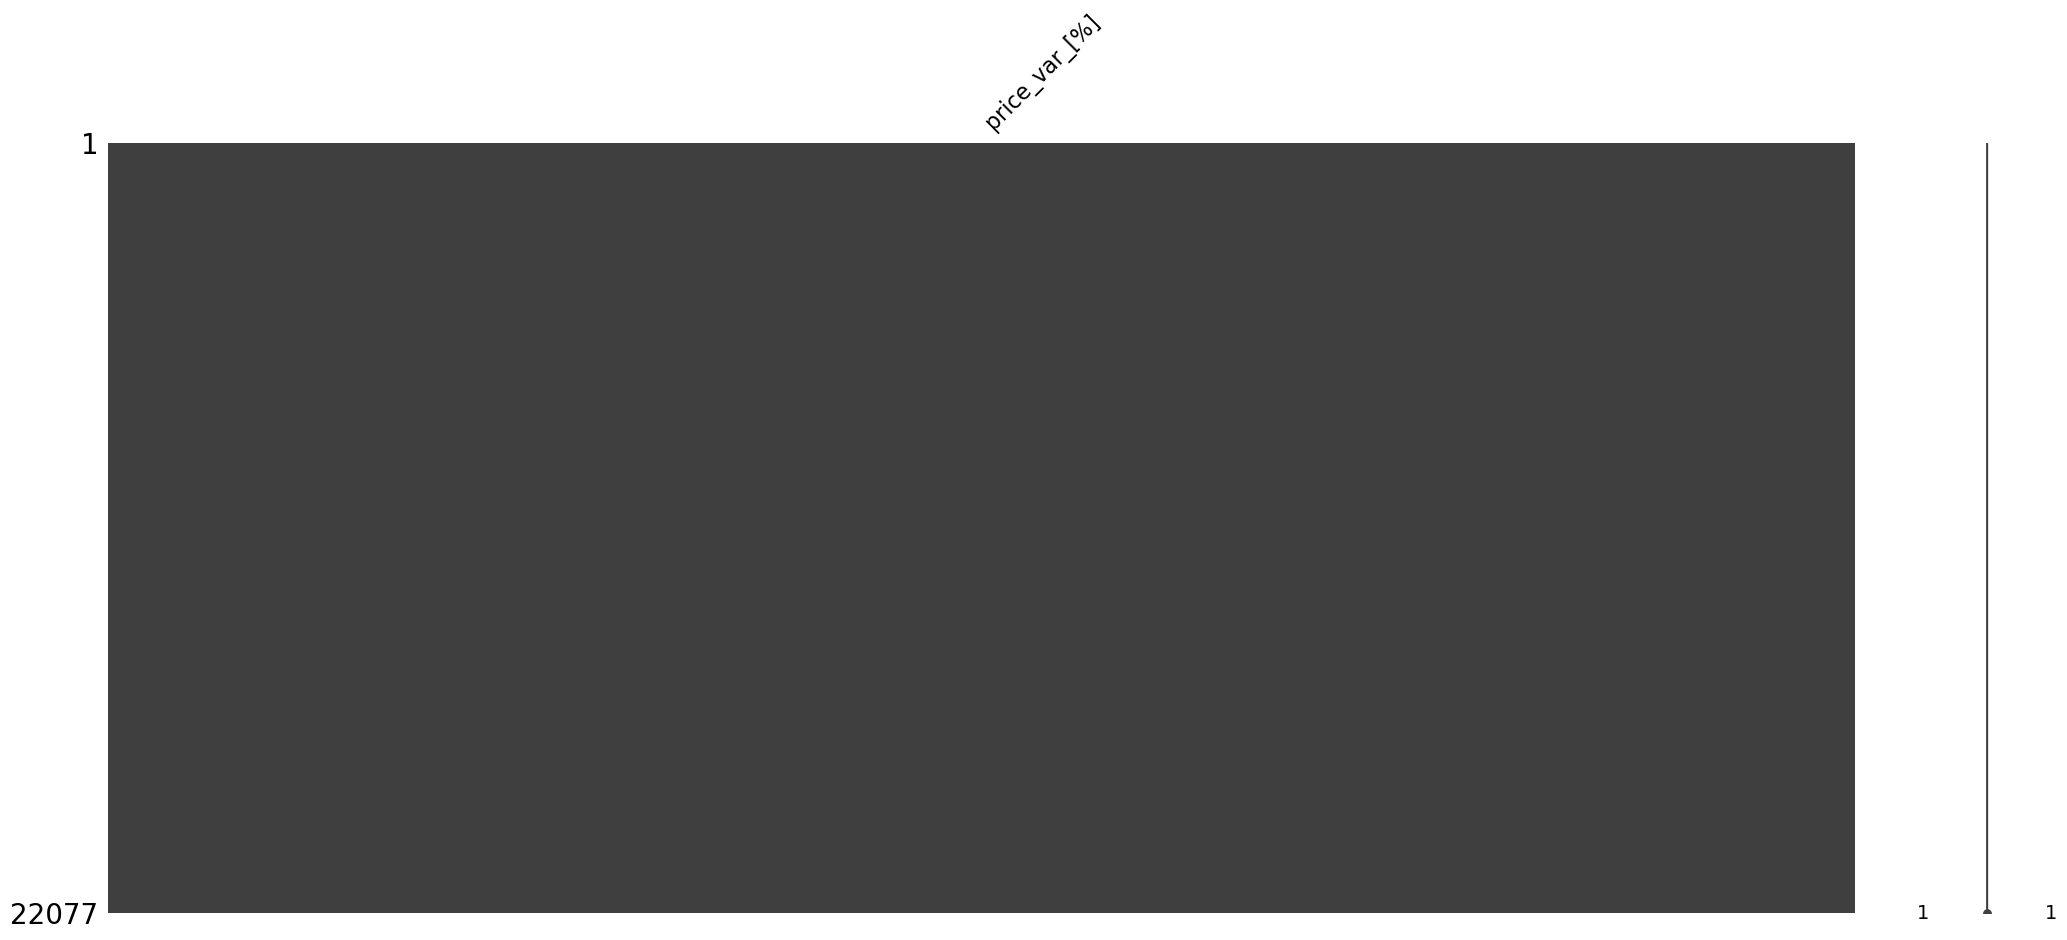

In [30]:
msno.matrix(price_var)

<Axes: >

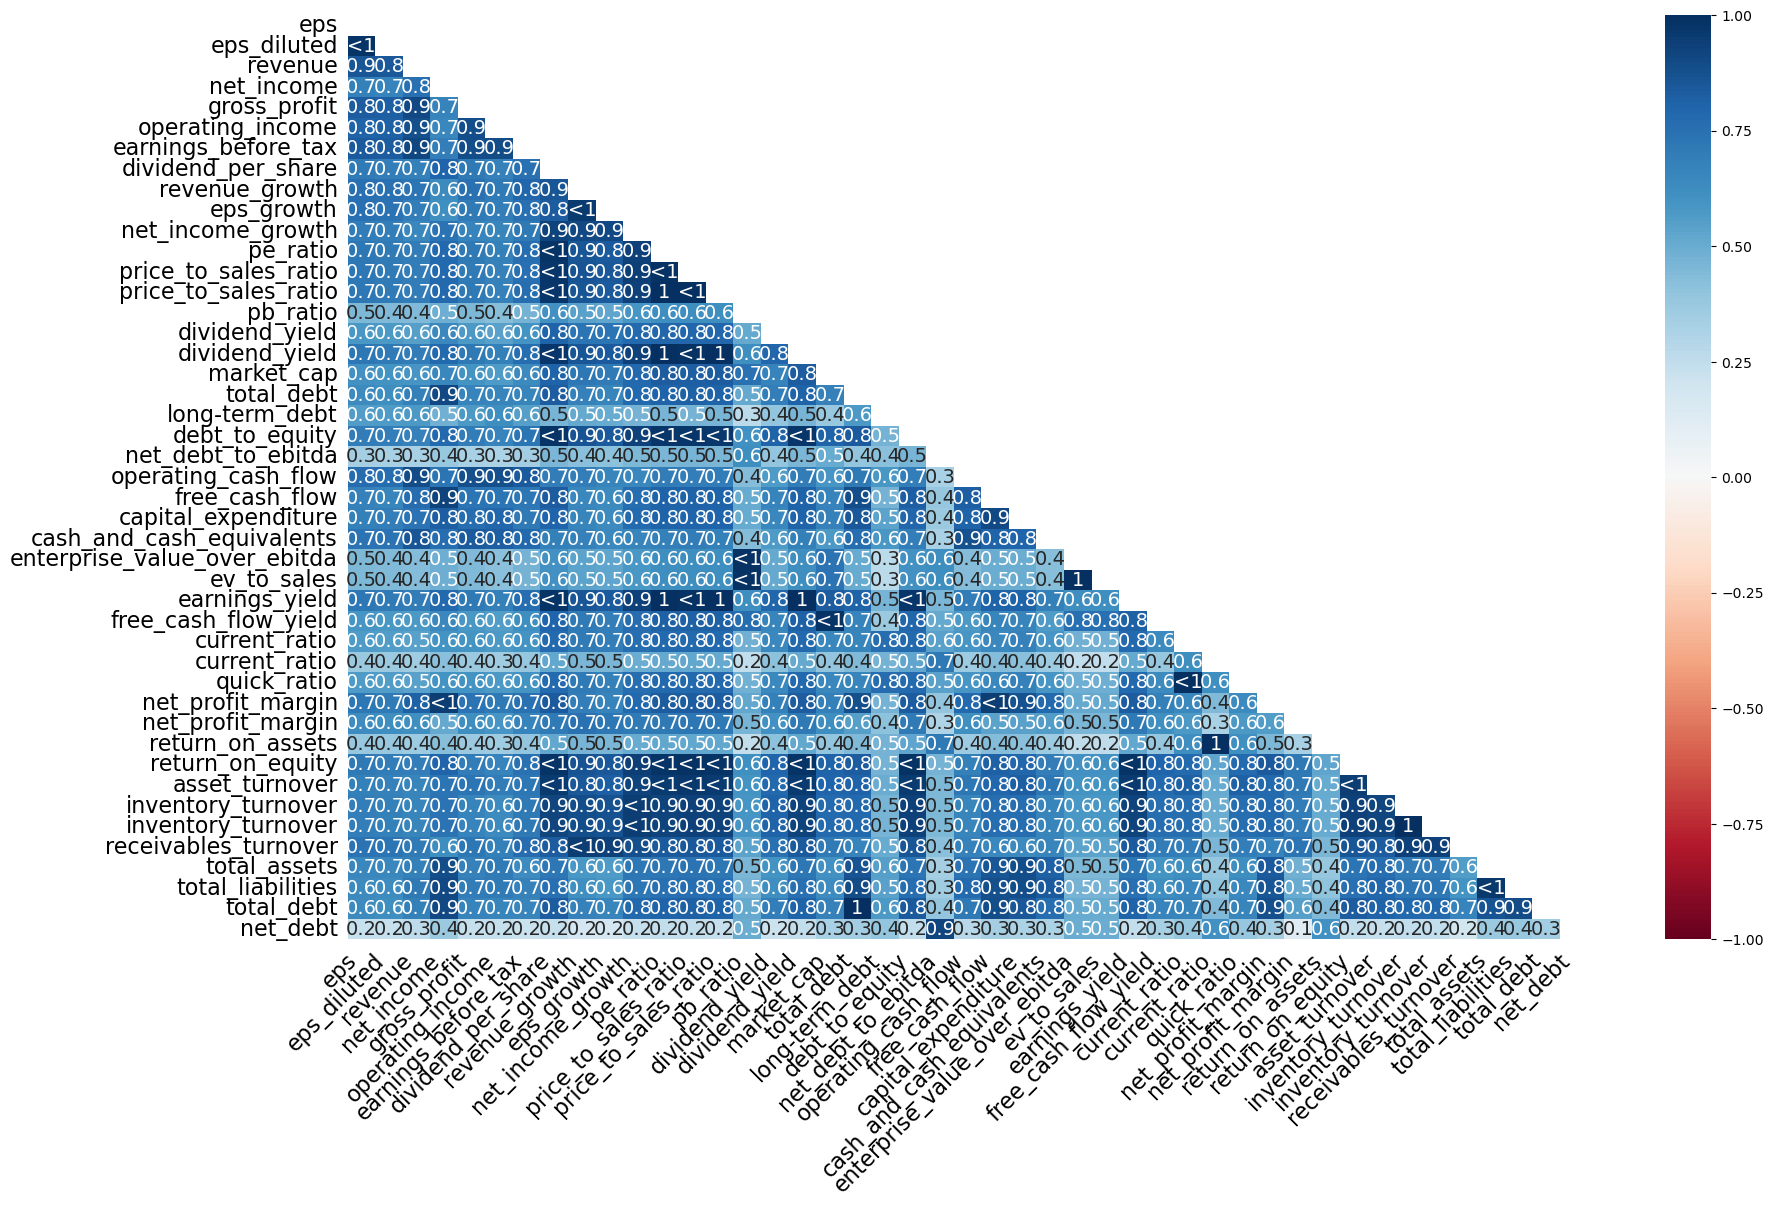

In [31]:
msno.heatmap(predictors_selected)

In [32]:
def non_missing_ratio_summary(df):
    """
    Calculate the ratio of non-missing (non-NA) data for each column in the DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame for which to calculate the non-missing ratios.

    Returns:
    - pandas.DataFrame: A DataFrame containing the non-missing ratios for each column.
    """
    # Calculate the total number of data points (number of rows)
    total_data_points = len(df)

    # Calculate the count of non-missing values for each column
    non_missing_counts = df.count()

    # Calculate the ratio of non-missing data points for each column
    non_missing_ratios = non_missing_counts / total_data_points

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Non_Missing_Count': non_missing_counts,
        'Non_Missing_Ratio': non_missing_ratios
    })

    return summary_df

<Axes: >

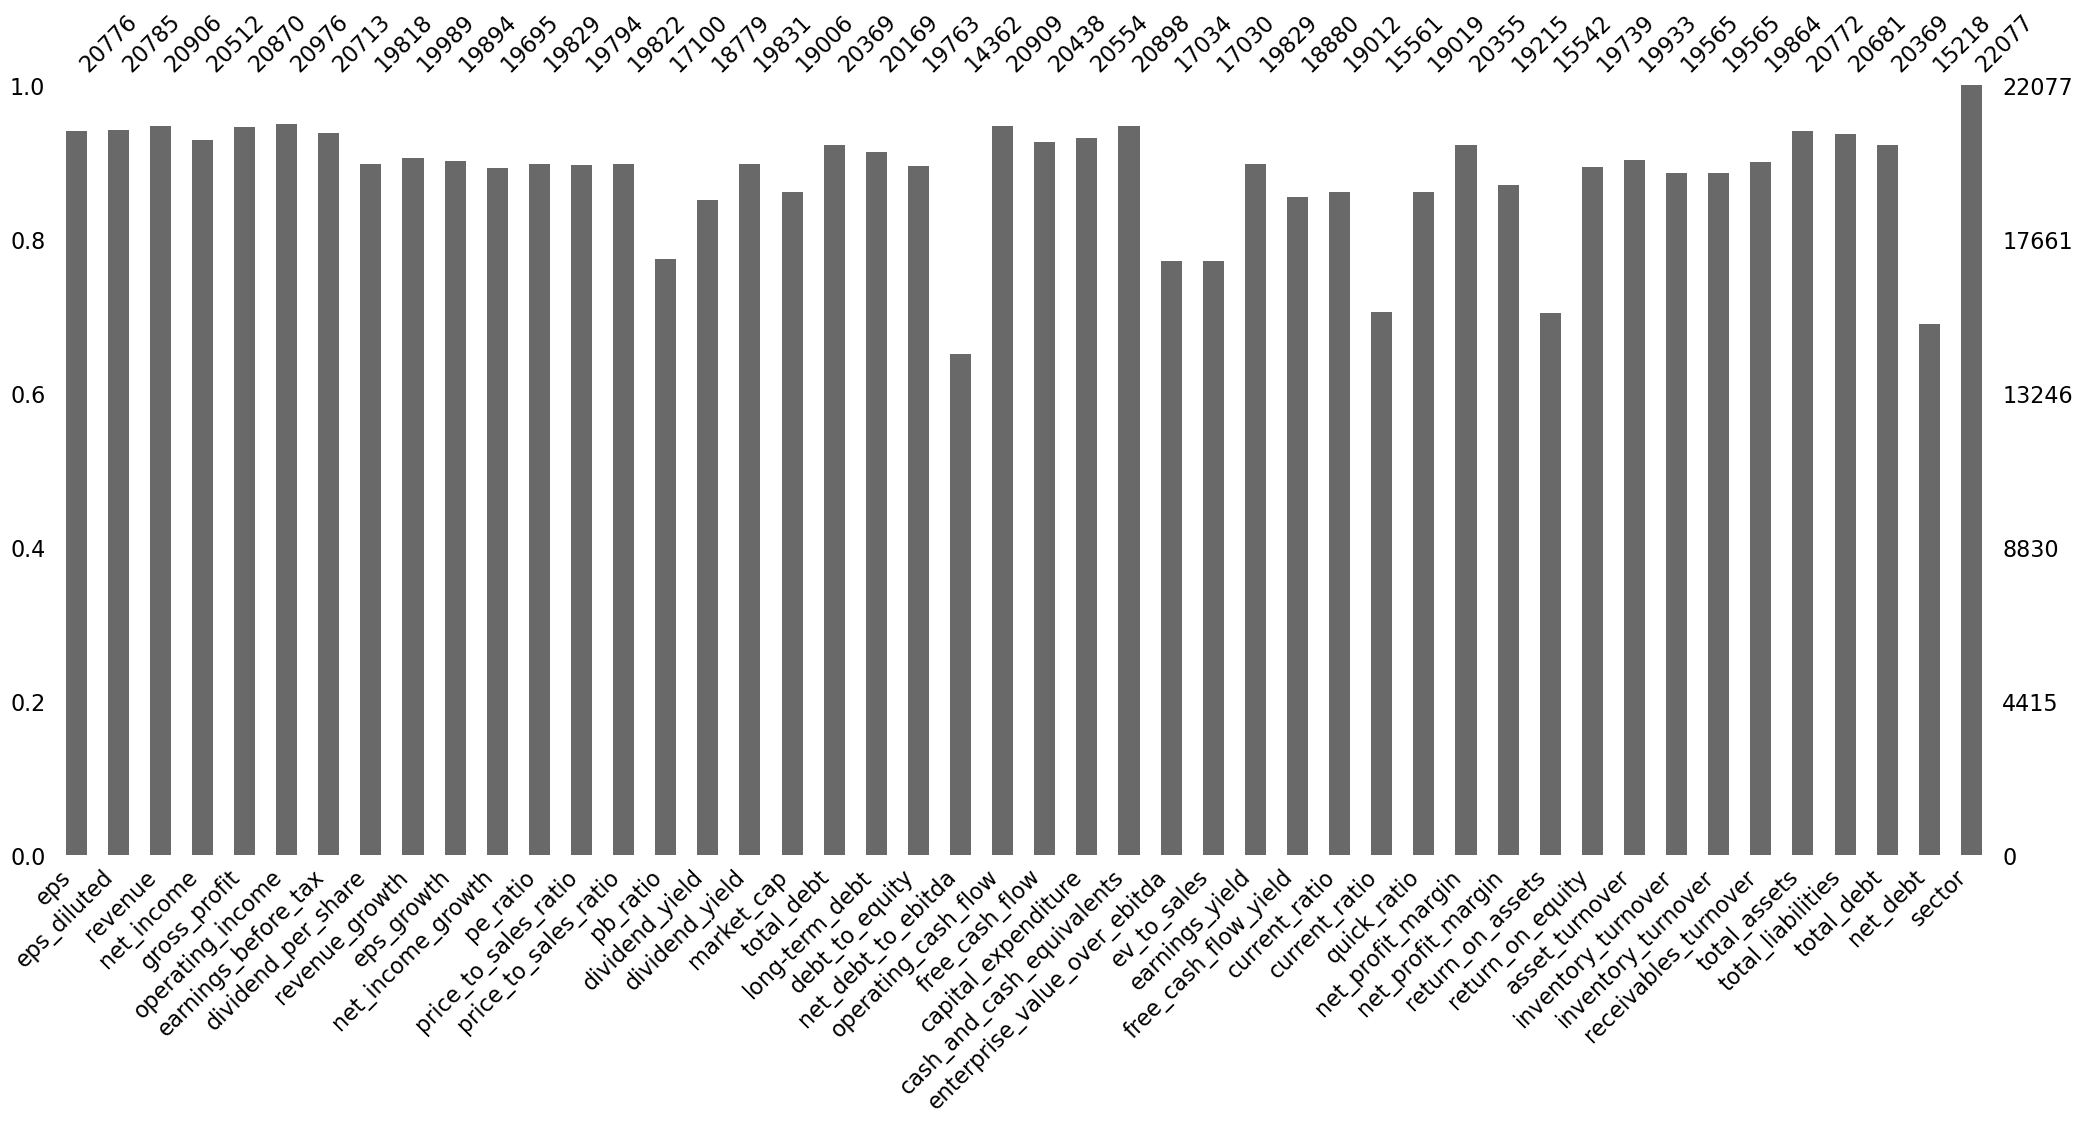

In [33]:
predictors_non_miss_summary = non_missing_ratio_summary(predictors_selected)
msno.bar(predictors_selected)

### Address Missingness

There are varying levels of missingness. 

1. If a column has a very high percentage of missing values, we will consider dropping the column. Will make sure to drop the column for all datasets from 2014 to 2018.
2. For other columns, we will impute them. We will need to determine the kind of missingness (MCAR, MAR, MNAR) to choose an appropriate imputation method. Based on our preliminary examination, it looks like the missingness is not MCAR, so we are not going to use mean or median imputation. In addition, basically all the features are numerical, so we will not be using mode imputation either. We also don't want to make any assumption about the distribution so regression imputation might not be a good choice here. Hence, so far the best solution will be kNN imputation.
3. We might want to add missing indicators to capture missingness patterns, maintain information, and improve our model interpretability.

In [34]:
# Specify a range of k values to try
k_values = range(1, 6)

# Create a list to store cross-validation scores
cv_scores = []

# Perform k-fold cross-validation for each k value
for k in k_values:
    imputer = KNNImputer(n_neighbors=k)

    imputed_data = imputer.fit_transform(df)
    
    # Calculate the mean squared error after imputation for each feature
    mse_per_feature = [mean_squared_error(df[col].dropna().values, imputed_data[:, i][~df[col].isna()]) for i, col in enumerate(df.columns)]
    
    # Take the average of MSE for all features
    mse = np.mean(mse_per_feature)
    
    # Store the metric's score
    cv_scores.append(mse)

# Find the best k value based on the lowest mean squared error
best_k = k_values[np.argmin(cv_scores)]
best_mse = min(cv_scores)

print("Cross-Validation Results:")
for k, mse in zip(k_values, cv_scores):
    print(f"k={k}: Mean Squared Error = {mse:.2f}")

print(f"Best k: k={best_k} with Mean Squared Error = {best_mse:.2f}")

ValueError: could not convert string to float: 'PG'

# Imbalance Issues

In [ ]:
predictors_selected.dtypes

Looks like only the target variable `class` and the predictor `sector` are categorical variables that might introduce imabalance issues. Let's invistigate then.

In [ ]:
def calculate_class_distribution_summary(df):
    """
    Generate a summary table showing the distribution of classes for categorical columns.

    Parameters:
    - df (pandas.DataFrame): The DataFrame for which to calculate class distributions.

    Returns:
    - pandas.DataFrame: A DataFrame containing the class distribution summary.
    """
    class_summary = pd.DataFrame()

    # Loop over categorical columns and calculate class distribution
    for col in df.select_dtypes(include=['object', 'category']).columns:
        # Get class distribution for the current column
        dist = df[col].value_counts(normalize=True).reset_index()
        dist.columns = ['Class', 'Percentage']
        dist['Feature'] = col
        dist['Count'] = df[col].value_counts().reset_index(drop=True)
        
        # Append to the summary DataFrame
        class_summary = pd.concat([class_summary, dist], ignore_index=True)

    return class_summary

In [ ]:
predictors_cat_sum = calculate_class_distribution_summary(predictors_selected)
print(predictors_cat_sum)

# Data Scaling

In [ ]:
def print_numeric_column_means(df):
    """
    Print the means of all numeric columns in the given DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame from which to calculate and print means.

    Returns:
    - None
    """
    # Select only the numeric columns of the DataFrame
    numeric_df = df.select_dtypes(include=['number'])

    # Calculate the mean of these numeric columns
    numeric_means = numeric_df.mean()

    # Print out the means of the numeric columns
    print("Means of numeric columns:")
    for col, mean_val in numeric_means.items():  # Changed from .iteritems() to .items()
        # Check if the value is a number (float or int)
        if isinstance(mean_val, (float, int)):
            print(f"{col}: {mean_val:.2f}")
        else:
            print(f"{col}: {mean_val} (Non-numeric value)")


In [ ]:
print_numeric_column_means(predictors_selected)

It looks like our features have very different scales. For instance, revenue is in the billions while eps_growth is close to zero. Such disparities can indeed cause issues with many machine learning algorithms that are sensitive to the scale of the data, particularly those that use distance measures (like k-NN, SVMs, and gradient descent-based algorithms like logistic regression).

### Address Scaling

We don't want to make any assumption about the distribution of our data. Hence, we will normalize our data (Min-Max Scaling). Normalization rescales the data to a fixed range, typically \[0, 1\].